<a href="https://colab.research.google.com/github/RizkyBagusParamadani30/Boids-and-SFM/blob/main/Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random State untuk posisi dan kecepatan

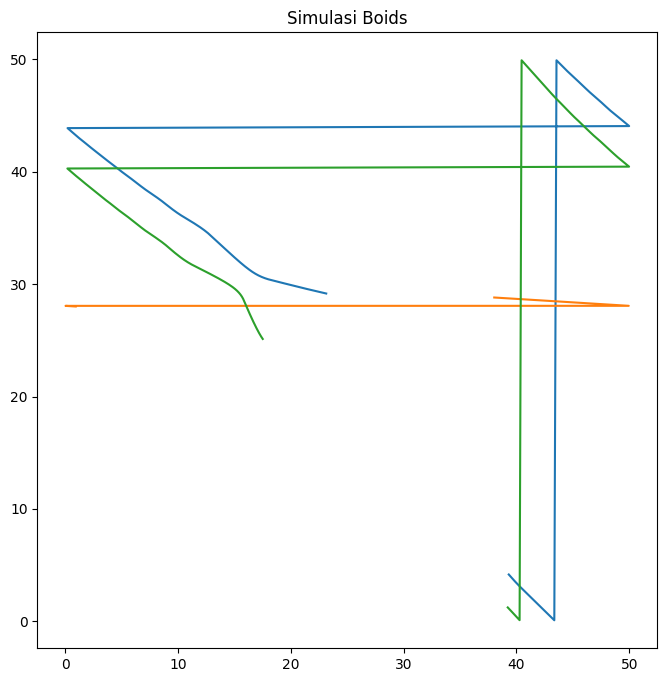

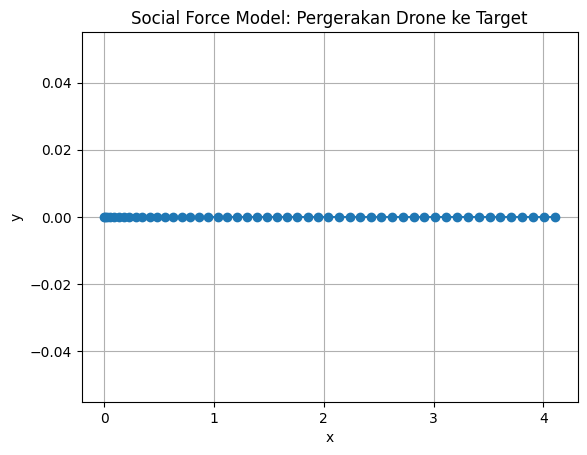

In [22]:
# boids_sfm.ipynb
import numpy as np
import matplotlib.pyplot as plt

# ==== Boids Parameters ====
N = 3
steps = 200
dt = 0.1
space = 50


# inisialisasi posisi dan kecepatan
pos = np.random.rand(N,2)*space
vel = (np.random.rand(N,2)-0.5)*2

neighbor_radius = 10
sep_radius = 3
w_sep, w_align, w_coh = 1.5, 1.0, 1.0
max_speed, max_force = 3.0, 0.5

def limit(v, maxval):
    n = np.linalg.norm(v)
    if n > maxval and n>0:
        return v/n*maxval
    return v

# rekam trajektori
traj = np.zeros((steps,N,2))
traj[0]=pos

for t in range(steps-1):
    new_vel = vel.copy()
    for i in range(N):
        diffs = pos - pos[i]
        dists = np.linalg.norm(diffs,axis=1)
        neighbors = (dists>0)&(dists<neighbor_radius)

        # Separation
        sep_force=np.zeros(2)
        close = (dists>0)&(dists<sep_radius)
        if np.any(close):
            sep_force = -np.sum(diffs[close]/dists[close][:,None],axis=0)
            sep_force=limit(sep_force,max_force)

        # Alignment
        align_force=np.zeros(2)
        if np.any(neighbors):
            avg_vel = np.mean(vel[neighbors],axis=0)
            desired = avg_vel/np.linalg.norm(avg_vel+1e-8)*max_speed
            align_force = limit(desired-vel[i],max_force)

        # Cohesion
        coh_force=np.zeros(2)
        if np.any(neighbors):
            center = np.mean(pos[neighbors],axis=0)
            desired = center-pos[i]
            desired = desired/np.linalg.norm(desired+1e-8)*max_speed
            coh_force = limit(desired-vel[i],max_force)

        force = w_sep*sep_force+w_align*align_force+w_coh*coh_force
        force=limit(force,max_force)

        new_vel[i]=limit(vel[i]+force*dt,max_speed)

    vel=new_vel
    pos=pos+vel*dt
    pos=pos%space
    traj[t+1]=pos

# plot hasil
plt.figure(figsize=(8,8))
for i in range(N):
    plt.plot(traj[:,i,0],traj[:,i,1])
plt.title("Simulasi Boids")
plt.show()

# ==== Social Force Model sederhana ====
m=1; tau=1; v0=np.array([1.0,0.0])
pos_sfm=np.array([0.0,0.0]); v=np.array([0.0,0.0])
pos_hist=[pos_sfm.copy()]

for t in range(50):
    F_goal=m/tau*(v0-v)
    a=F_goal/m
    v=v+a*dt
    pos_sfm=pos_sfm+v*dt
    pos_hist.append(pos_sfm.copy())

pos_hist=np.array(pos_hist)
plt.plot(pos_hist[:,0],pos_hist[:,1],'-o')
plt.title("Social Force Model: Pergerakan Drone ke Target")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True)
plt.show()


#Manually Set

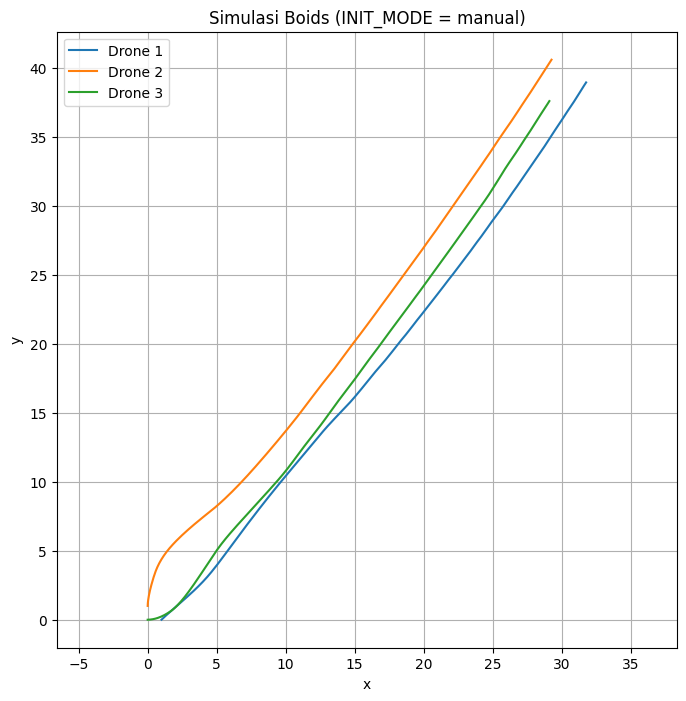

/tmp/ipython-input-1033088212.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


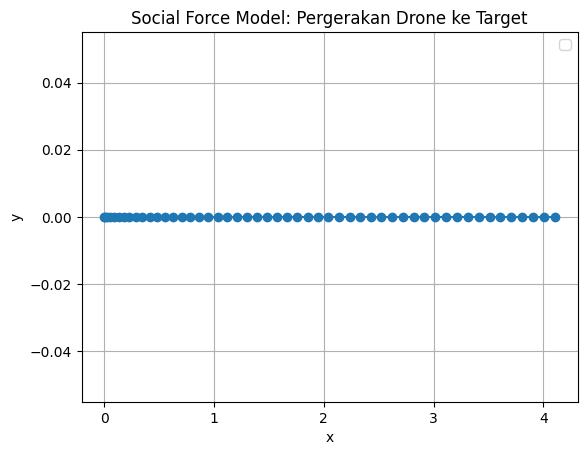

In [23]:
# boids_sfm.ipynb (fixed initial positions)
import numpy as np
import matplotlib.pyplot as plt

# ==== Boids Parameters ====
N = 4
steps = 200
dt = 0.1
space = 50.0

neighbor_radius = 10.0
sep_radius = 3.0
w_sep, w_align, w_coh = 1.5, 1.0, 1.0
max_speed, max_force = 3.0, 0.5

# ============================
# Pilih formasi awal:
# 'manual' : 4 boid di sudut persegi
# 'grid'   : grid 5x4
# 'circle' : formasi lingkaran
# ============================
INIT_MODE = 'manual'   # 'manual' | 'grid' | 'circle'

def limit(v, maxval):
    n = np.linalg.norm(v)
    if n > maxval and n > 0:
        return v / n * maxval
    return v

def init_state(mode):
    if mode == 'manual':
        # 4 boid di sudut persegi
        pos = np.array([
            [1, 0],
            [0, 1],
            [0, 0]
            # [20, 40]
        ], dtype=float)
        vel = np.array([
            [1.0, 1.0],
            [0.0, 1.0],
            [1.0, 0.0]
            # [2.5, 0.8]
        ], dtype=float)
        return pos, vel

    elif mode == 'grid':
        # Grid 5x4 (akan override N)
        x = np.linspace(8, 42, 5)
        y = np.linspace(10, 40, 4)
        X, Y = np.meshgrid(x, y)
        pos = np.vstack([X.ravel(), Y.ravel()]).T.astype(float)
        vel = np.tile(np.array([[0.7, 0.7]]), (pos.shape[0], 1)).astype(float)
        return pos, vel

    elif mode == 'circle':
        # Formasi lingkaran (akan override N)
        N_circle = 12
        radius = 18.0
        center = np.array([space/2, space/2], dtype=float)
        angles = np.linspace(0, 2*np.pi, N_circle, endpoint=False)
        pos = np.c_[radius*np.cos(angles)+center[0], radius*np.sin(angles)+center[1]].astype(float)
        # kecepatan tangensial
        tangent = np.c_[-np.sin(angles), np.cos(angles)]
        vel = (tangent * 1.0).astype(float)
        return pos, vel

    else:
        raise ValueError("INIT_MODE tidak dikenali.")

# Inisialisasi state
pos, vel = init_state(INIT_MODE)
N = pos.shape[0]  # update N jika grid/circle

# rekam trajektori
traj = np.zeros((steps, N, 2), dtype=float)
traj[0] = pos

# ====== Simulasi Boids ======
for t in range(steps-1):
    new_vel = vel.copy()
    for i in range(N):
        diffs = pos - pos[i]
        dists = np.linalg.norm(diffs, axis=1)
        neighbors = (dists > 0) & (dists < neighbor_radius)

        # Separation
        sep_force = np.zeros(2)
        close = (dists > 0) & (dists < sep_radius)
        if np.any(close):
            sep_force = -np.sum(diffs[close] / dists[close][:, None], axis=0)
            sep_force = limit(sep_force, max_force)

        # Alignment
        align_force = np.zeros(2)
        if np.any(neighbors):
            avg_vel = np.mean(vel[neighbors], axis=0)
            if np.linalg.norm(avg_vel) > 1e-8:
                desired = avg_vel / np.linalg.norm(avg_vel) * max_speed
            else:
                desired = vel[i]
            align_force = limit(desired - vel[i], max_force)

        # Cohesion
        coh_force = np.zeros(2)
        if np.any(neighbors):
            center = np.mean(pos[neighbors], axis=0)
            desired = center - pos[i]
            if np.linalg.norm(desired) > 1e-8:
                desired = desired / np.linalg.norm(desired) * max_speed
            else:
                desired = vel[i]
            coh_force = limit(desired - vel[i], max_force)

        force = w_sep*sep_force + w_align*align_force + w_coh*coh_force
        force = limit(force, max_force)

        new_vel[i] = limit(vel[i] + force*dt, max_speed)

    vel = new_vel
    pos = pos + vel*dt
    pos = pos % space
    traj[t+1] = pos

# plot hasil Boids
# plot hasil Boids
plt.figure(figsize=(8,8))
for i in range(N):
    plt.plot(traj[:, i, 0], traj[:, i, 1], label=f"Drone {i+1}")  # kasih label unik
plt.title(f"Simulasi Boids (INIT_MODE = {INIT_MODE})")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True)
plt.axis("equal")
plt.legend(loc="best")   # tampilkan legenda
plt.show()

# ==== Social Force Model sederhana (tidak di-random) ====
m = 1.0
tau = 1.0
v0 = np.array([1.0, 0.0])
pos_sfm = np.array([0.0, 0.0])
v = np.array([0.0, 0.0])
pos_hist = [pos_sfm.copy()]

for t in range(50):
    F_goal = m/tau * (v0 - v)
    a = F_goal / m
    v = v + a*dt
    pos_sfm = pos_sfm + v*dt
    pos_hist.append(pos_sfm.copy())

pos_hist = np.array(pos_hist)
plt.figure()
plt.plot(pos_hist[:, 0], pos_hist[:, 1], '-o')
plt.title("Social Force Model: Pergerakan Drone ke Target")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc="best")
plt.grid(True)
plt.show()
